# Solar Modelling

- Location: Singapore (1.3521, 103.8198)
- Time period: 1 Jan 2022 to 1 Jan 2023

Optimal angle algorithm (time_step = 1 minute)
1. Obtain general information (location, time)
2. Gather solar geometric data
3. List candidate angles with fixed increment
4. For each candidate angle, calculate irradiance and insolation generated
4. Get maximum insolation and output candidate angle

Reference: [On the Optimal Tilt Angle and Orientation of an On-Site Solar Photovoltaic Energy Generation System for Sabah’s Rural Electrification](https://www.mdpi.com/2071-1050/13/10/5730)

## Cases
1. Horizontal (surface tilt = 0, surface_azimuth = 0)
2. Daily tracking (Every 24 hours)
3. Quad-hourly tracking (Every 4 hours)
4. Bi-hourly tracking (Every 2 hours)
5. Hourly tracking (Every hour)
6. Half-hourly tracking (Every 30 minutes)
6. Minutely tracking (Every minute)

In [1]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
class Experiment:
    def __init__(
            self, start, lat=1.3521, lon=103.8198, tz="Asia/Kuala_Lumpur", 
            freqs=[1440, 240, 120, 60, 30, 1]):
        self._tz = tz
        self._days = 1
        self._start = start
        self._end = start + datetime.timedelta(self._days)
        self._location = pvlib.location.Location(lat, lon, tz)
        self._solar_data = self._get_solardata()
        self._sunrise, self._sunset = self._get_solarday()
        self._build_cases(freqs)
    
    def _get_solardata(self):
        times = pd.date_range(self._start, self._end, freq="1min", tz=self._tz, closed="left")
        solar_position = self._location.get_solarposition(times)
        clearsky = self._location.get_clearsky(times, solar_position=solar_position)
        solar_position = solar_position.merge(clearsky, left_index=True, right_index=True)
        columns = ['elevation', 'zenith', 'azimuth', 'ghi', 'dni', 'dhi']
        solar_position = solar_position.loc[:, columns].rename(columns=
            {'zenith': 'solar_zenith', 'azimuth': 'solar_azimuth'})
        solar_position = solar_position.reset_index(drop=True)
        return solar_position

    def _gather_irradiance(self, solar_data, surface_tilt=None, surface_azimuth=None):
        irrad_records = []
        for _, row in solar_data.iterrows():
            if row['elevation'] > 0:
                irrad = dict(pvlib.irradiance.get_total_irradiance(
                    surface_tilt=surface_tilt if surface_tilt != None else row['solar_zenith'],
                    surface_azimuth=surface_azimuth if surface_azimuth != None else row['solar_azimuth'],
                    solar_zenith=row['solar_zenith'],
                    solar_azimuth=row['solar_azimuth'],
                    dni=row['dni'],
                    ghi=row['ghi'],
                    dhi=row['dhi']))
                irrad = {
                    'total': irrad['poa_global'],
                    'direct': irrad['poa_direct'],
                    'diffuse': irrad['poa_diffuse']}
            else:
                irrad = {
                    'total': 0,
                    'direct': 0,
                    'diffuse': 0}
            irrad_records.append(irrad)    
        return irrad_records

    def _get_optimal_angle(self, solar_data, mode="tilt"):
        upper_limit = 91 if mode == "tilt" else 361
        increment = 5 if mode == "tilt" else 15
        angles = np.arange(0, upper_limit, increment)
        optimal_angle, optimal_insolation = 0, 0
        for angle in angles:
            irrad_array = []
            for _, row in solar_data.iterrows():
                irrad = dict(pvlib.irradiance.get_total_irradiance(
                    surface_tilt=angle if mode == "tilt" else row['solar_zenith'],
                    surface_azimuth=angle if mode == "orient" else row['solar_azimuth'],
                    solar_zenith=row['solar_zenith'],
                    solar_azimuth=row['solar_azimuth'],
                    dni=row['dni'],
                    ghi=row['ghi'],
                    dhi=row['dhi']))['poa_global']
                irrad_array.append(irrad)
            H = np.trapz(irrad_array)
            if H > optimal_insolation:
                optimal_insolation = H
                optimal_angle = angle
        return optimal_angle

    def _get_solarday(self):
        solar_periods = self._solar_data.query("elevation > 0")
        return solar_periods.index[0], solar_periods.index[-1]

    def _step_tracking(self, freq):    
        if freq == 1:
            irrad = self._gather_irradiance(self._solar_data)
        else:
            n_rows = self._solar_data.shape[0]
            irrad = []
            # Loop through time periods
            for i in np.arange(0, n_rows+1, freq):
                # Slice solar data for time period
                sub_data = self._solar_data.iloc[i:i+freq, :]
                
                surface_tilt = self._get_optimal_angle(sub_data, mode="tilt")
                surface_azimuth = self._get_optimal_angle(sub_data, mode="orient")

                # Loop per minute within time period
                sub_irrad = self._gather_irradiance(sub_data, surface_tilt, surface_azimuth)
                irrad.extend(sub_irrad)

        return pd.DataFrame(irrad)

    def _build_cases(self, freqs):
        case_0 = pd.DataFrame(self._gather_irradiance(
            self._solar_data, surface_tilt=0, surface_azimuth=0))

        self._cases = [case_0] + [self._step_tracking(freq) for freq in freqs]

    def plot_irradiance(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
        for i, col in enumerate(['total', 'direct', 'diffuse']):
            case_dict = {}
            for j, case in enumerate(self._cases):
                case_dict[f"Case {j+1}"] = case[col]

            pd.DataFrame.from_dict(case_dict).plot(ax=ax[i], title=col, xlabel="time (m)", ylabel="irradiance (W/m^2)")

        plt.suptitle(self._start.strftime("%D"))
        plt.tight_layout()
        plt.show()

    def plot_insolation(self):
        fig = plt.figure(figsize=(10,6))
        for i, case in enumerate(self._cases):
            insolation = np.trapz(case['total'])
            plt.barh(i+1, insolation)

        plt.xlabel("insolation (J/m^2)")
        plt.ylabel("cases")
        plt.title(self._start.strftime("%D"))
        plt.show()

# Plot

Tracking frequency does not affect diffuse irradiance.

Quad-hourly tracking will suffice.

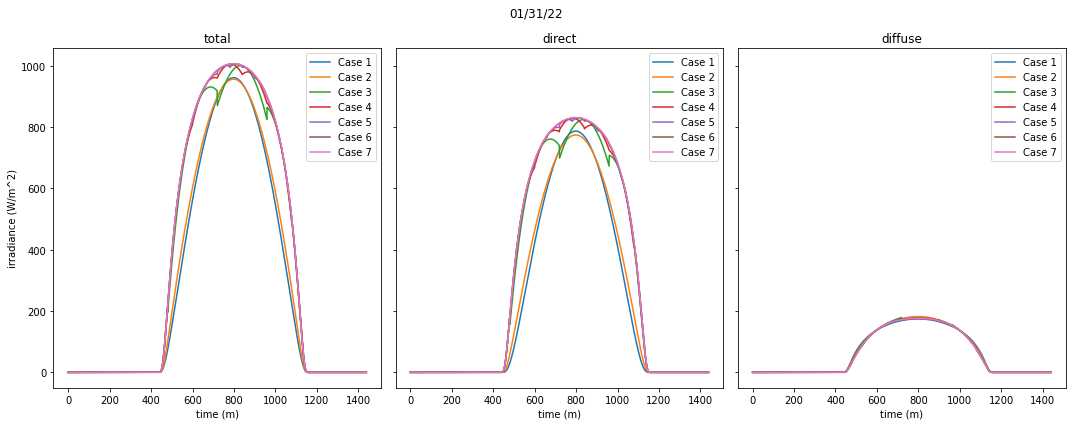

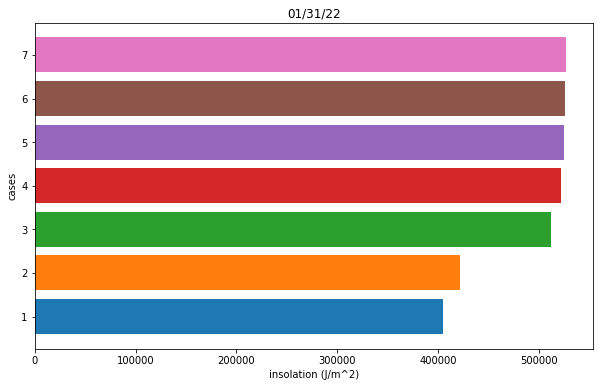

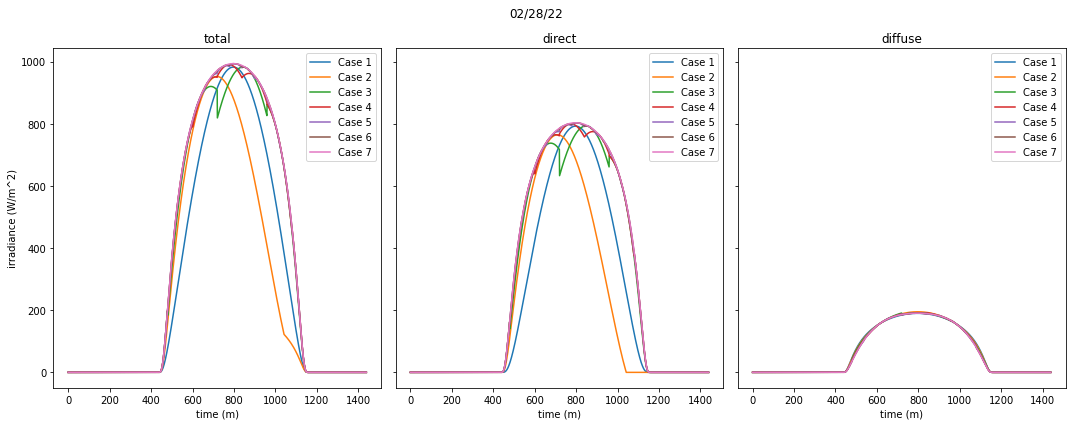

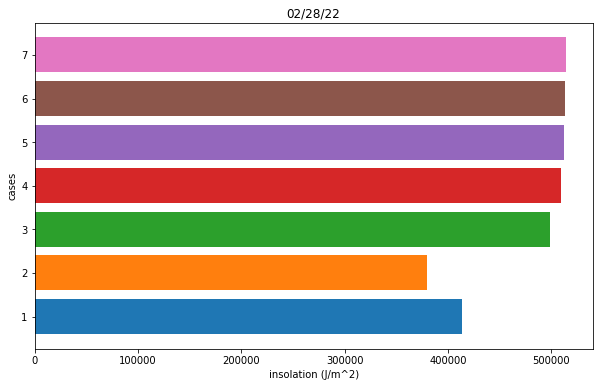

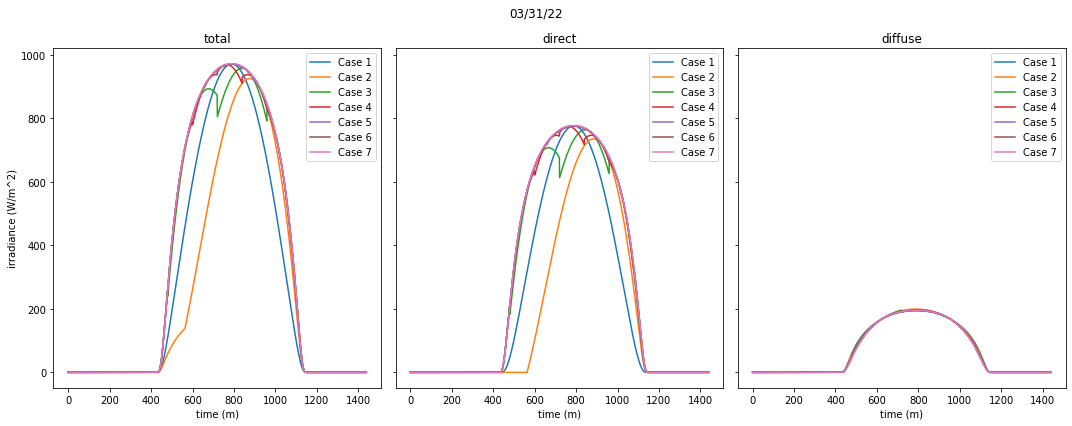

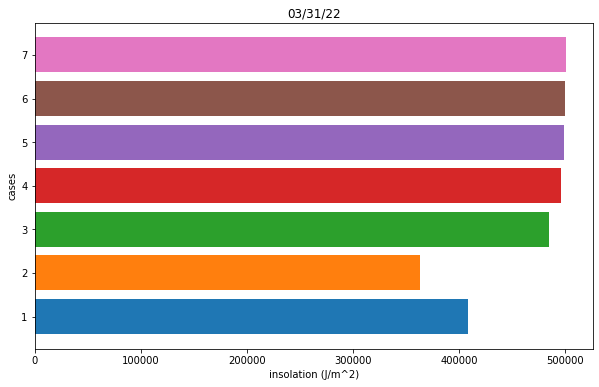

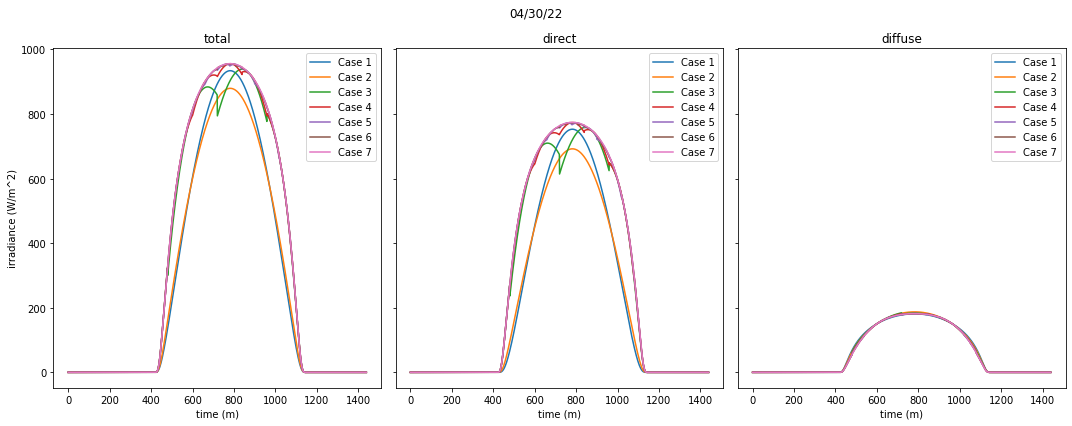

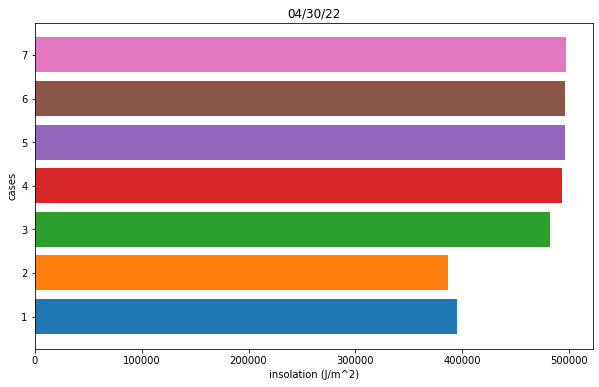

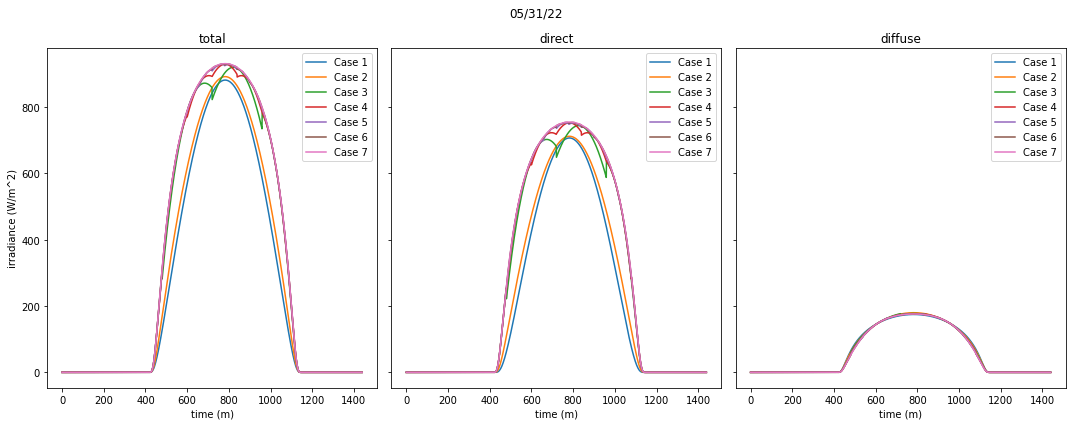

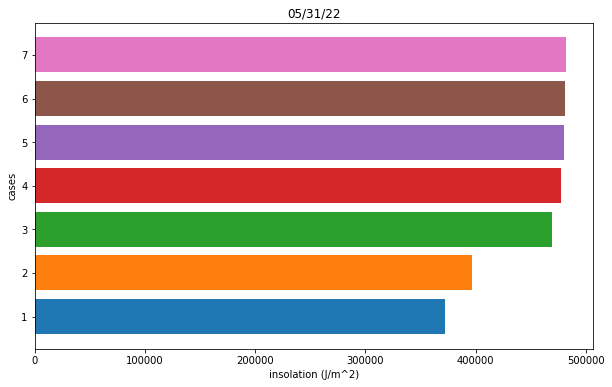

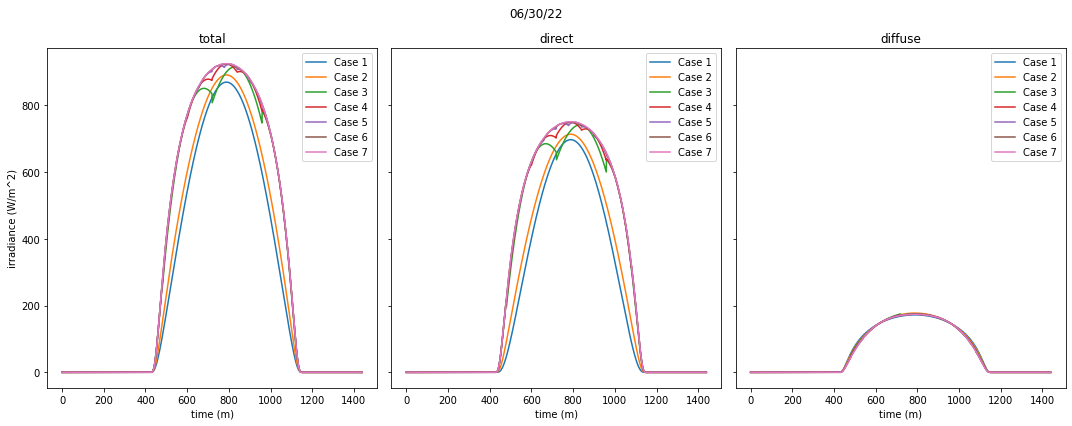

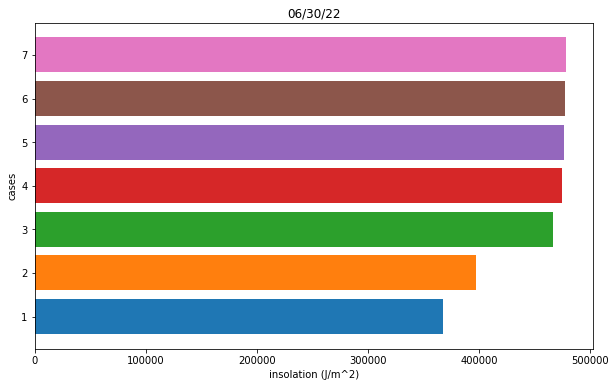

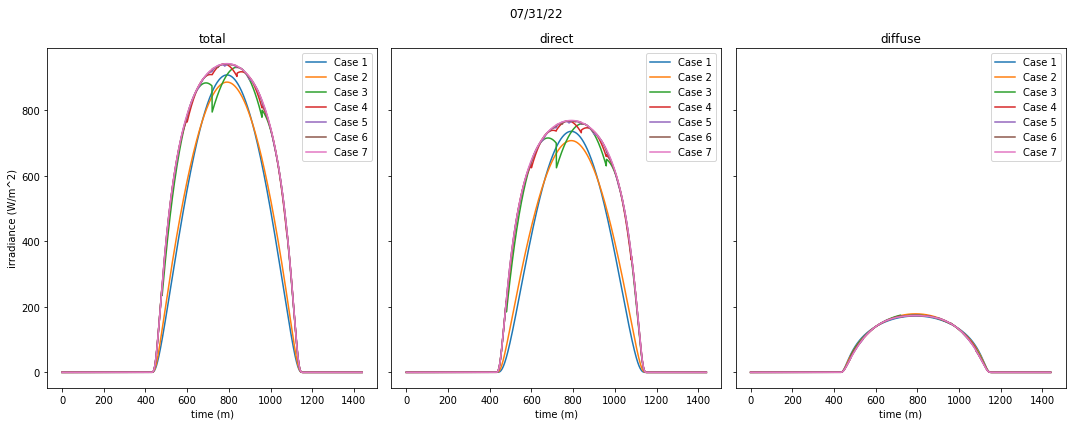

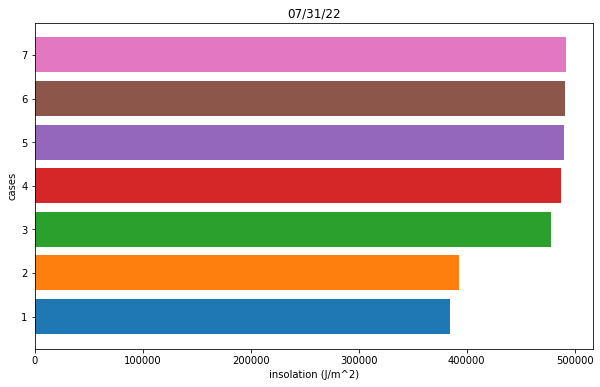

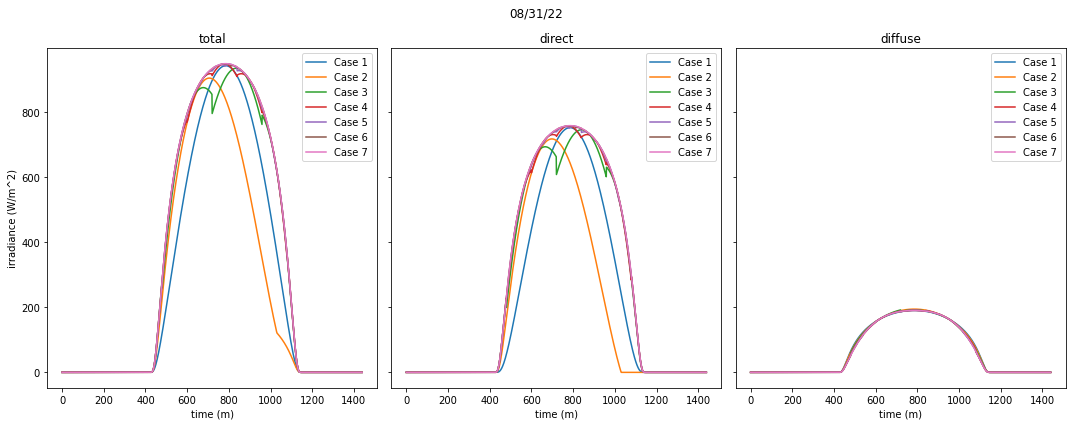

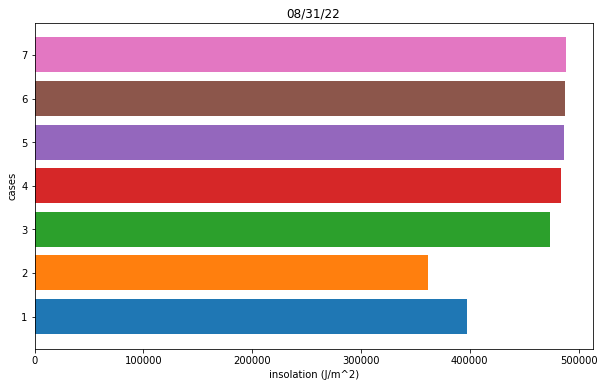

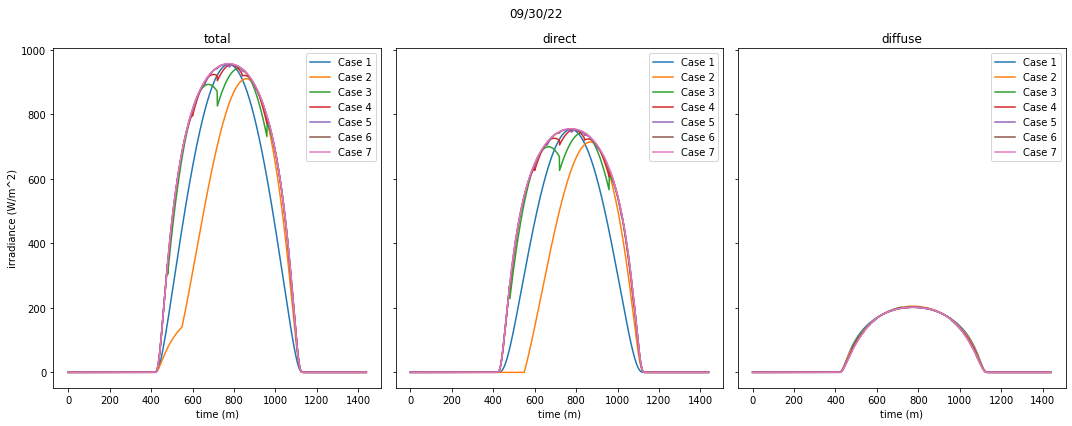

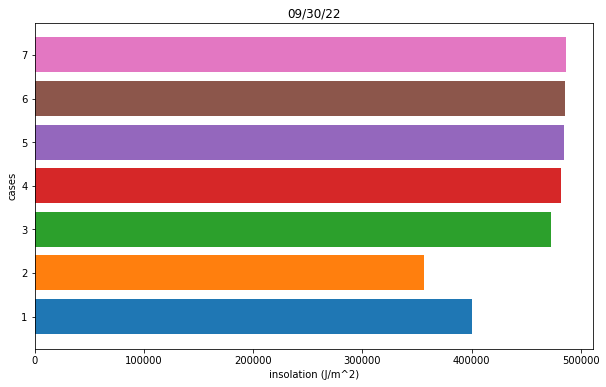

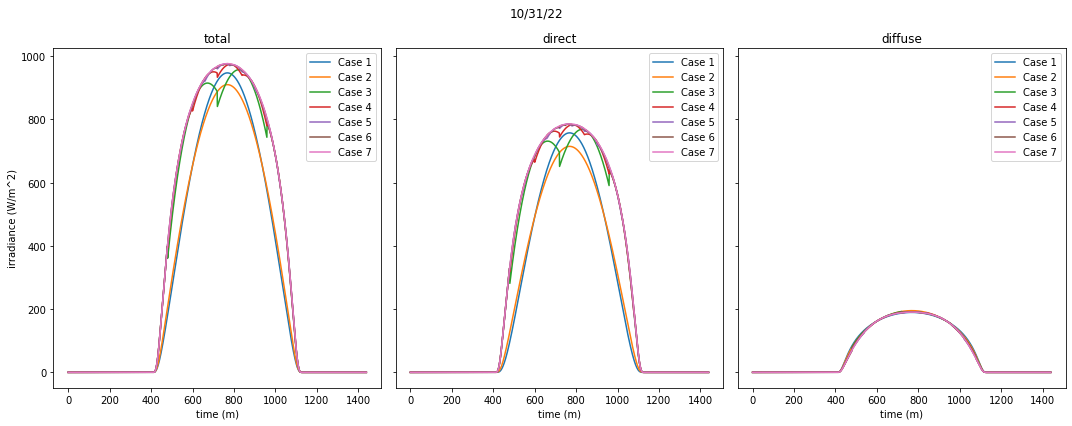

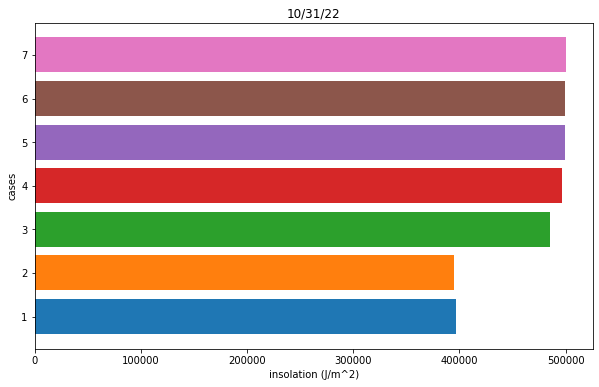

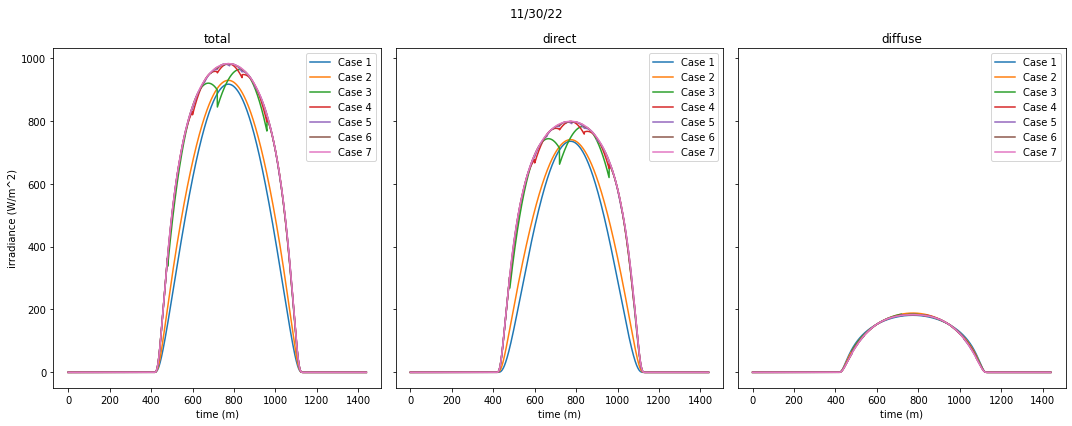

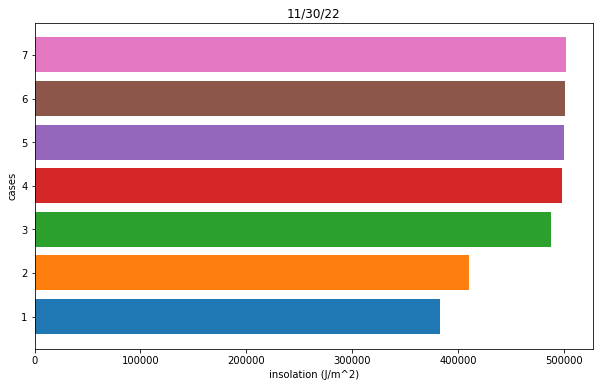

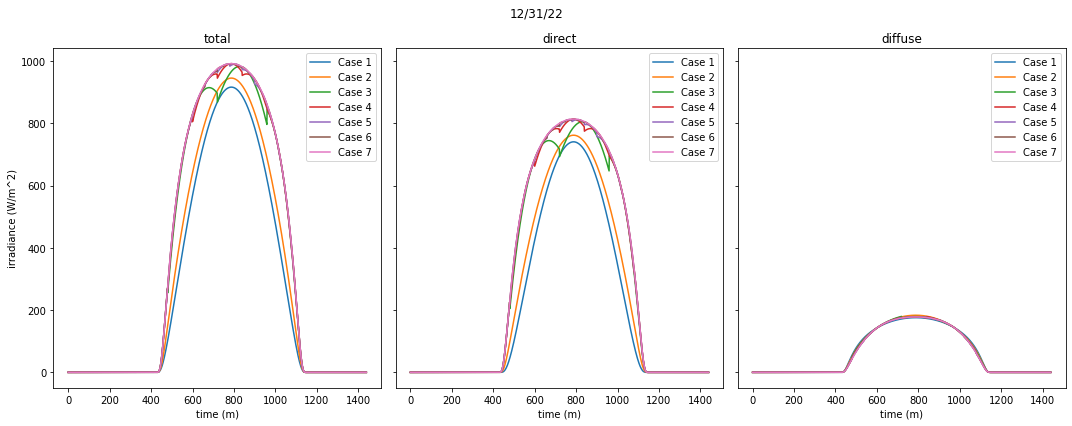

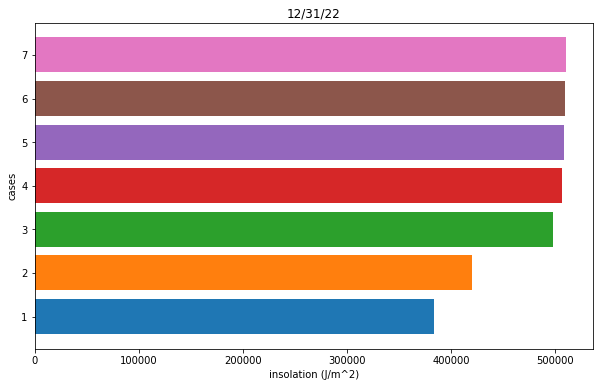

In [3]:
start_date = datetime.datetime(2022, 1, 21, 0, 0, 0)
end_date = start_date + datetime.timedelta(days=365)
date_range = pd.date_range(start_date, end_date, tz="Asia/Kuala_Lumpur", freq="1M")

for start in date_range:
    ex = Experiment(start)
    ex.plot_irradiance()
    ex.plot_insolation()